## Deep Crossentropy method 

We'll extend your CEM implementation with neural networks!

In [9]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

state vector dim = 4
n_actions = 2


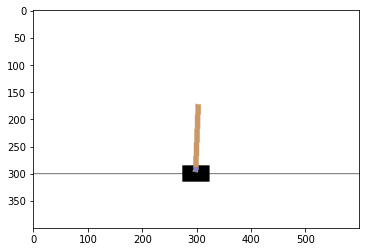

In [10]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

## Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from Scikit-learn. Here's what you'll need:

`agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
`agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape [len(states), n_actions]

In [11]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [12]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])
        probs = np.reshape(probs, (n_actions,))
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        val = np.random.choice(probs)
        a = list(probs).index(val)
        
        # ^-- hint: try np.random.choice
        
        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [13]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 0.02403791  0.0191592  -0.02173548 -0.04790791]
 [ 0.02442109  0.21458596 -0.02269363 -0.34736855]
 [ 0.02871281  0.41002323 -0.02964101 -0.64712032]
 [ 0.03691328  0.60554535 -0.04258341 -0.94898785]
 [ 0.04902418  0.41102176 -0.06156317 -0.66998273]]
actions: [1, 1, 1, 0, 0]
reward: 5.0


## CEM steps

In [14]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
  """
  Select states and actions from games that have rewards >= percentile
  :param states_batch: list of lists of states, states_batch[session_i][t]
  :param actions_batch: list of lists of actions, actions_batch[session_i][t]
  :param rewards_batch: list of rewards, rewards_batch[session_i]

  :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

  Please return elite states and actions in their original order 
  [i.e. sorted by session number and timestep within session]

  If you are confused, see examples below. Please don't assume that states are integers
  (they will become different later).
  """

  reward_threshold = np.percentile(rewards_batch, percentile)
  elite_states = []
  elite_actions = []
  print(reward_threshold)
  for i in range(len(rewards_batch)):
    if rewards_batch[i] >= reward_threshold:
      elite_states += states_batch[i]
      elite_actions += actions_batch[i]
  return elite_states, elite_actions

## Training Loop

In [15]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 22.570, threshold=24.300


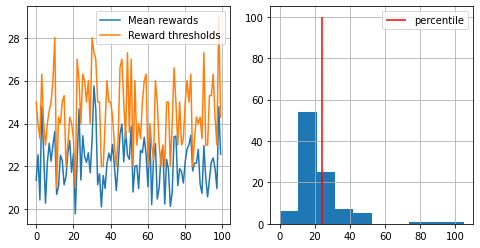

In [18]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
  sessions = []
  for _ in range(n_sessions):
    sessions.append(generate_session(env, agent))
  # print(sessions)
  states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

  # partial_fit agent to predict elite_actions(y) from elite_states(X)>
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

  if np.mean(rewards_batch) > 190:
      print("You Win! You may stop training now via KeyboardInterrupt.")

## Results

In [19]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

In [20]:
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))